# Ensemble Class code

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
data_digit = load_digits()
X = data_digit['data']
y = data_digit['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

regular_clfs = [
    (
        "Naive Bayes",GaussianNB()
            
        ),
    (
        "Decision Tree",DecisionTreeClassifier())
        ]
for name, clf in regular_clfs :
    print(name)
    clf.fit(X_train,y_train)
    print(f"f1 train - {f1_score(clf.predict(X_train),y_train, average = 'macro')}")
    print(f"f1 test - {f1_score(clf.predict(X_test),y_test, average = 'macro')}" )
    print(f'accuracy = {accuracy_score(clf.predict(X_test),y_test)}')

Naive Bayes
f1 train - 0.849402587965802
f1 test - 0.8451174159675487
accuracy = 0.8462962962962963
Decision Tree
f1 train - 1.0
f1 test - 0.8432539783847799
accuracy = 0.8425925925925926


We can see that Decision tree on the training set is super accurate-- overfitting.

## Bagging

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
bagging_nb = BaggingClassifier(base_estimator=GaussianNB(), max_samples = 0.2, #
                               n_estimators=100,oob_score = True).fit(X_train,y_train) #estimators-- amount of classifiers to use.
                                                                                     #oob score- out of the box score-- the samples which werent used, their generaliztion error.


In [9]:
bagging_nb.oob_score_ #Out f bag score-- testing the samples which weren't sampled by the bagging, against the training data (used as a sort of validation set)

0.8719172633253779

making the right oob evaluation metric and not just accuracy

In [12]:
import numpy as np

def macro_f1_score_oob(bagging_model,y_train_):
    oob_preds = np.argmax(bagging_model.oob_decision_function_,axis=1)
    return f1_score(y_train_, oob_preds,average = 'macro') #https://tomaxent.com/2018/04/27/Micro-and-Macro-average-of-Precision-Recall-and-F-Score/
                                                            #macro average-- Take the average precision among all classifiers, and the average recal among all classifiers, and find the harmonic mean (F1)
    
macro_f1_score_oob(bagging_nb,y_train)

0.8722679997970155

In [13]:
RANDOM_STATE = 21

In [14]:
from collections import OrderedDict
import matplotlib.pyplot as plt

ensemble_clfs = [
    (
        "Bagging Naive Bayes",
        BaggingClassifier(base_estimator=GaussianNB(),
                               n_estimators=100,oob_score = True, random_state=RANDOM_STATE)
            
        ),
    (
        "Bagging Decision Tree",
        BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                               n_estimators=100,oob_score = True, random_state=RANDOM_STATE)
    ),
    (
        "Random Forest Classifier",RandomForestClassifier( #WE don't implement the Bagging Classifier, because RandForest itself is a bagging method
                               n_estimators=100,oob_score = True, random_state=RANDOM_STATE) #Difference between bagging of decision tree and random forest is the feature selection.
                                                                                            #
    )]

macro_f1_score_oobs = OrderedDict((label, []) for label, _ in ensemble_clfs)
macro_f1_score_test = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_train,y_train)

        oob_f1 =  macro_f1_score_oob(clf,y_train) 
        macro_f1_score_oobs[label].append((i, oob_f1))



C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\ensemble\_bagging.py:707: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\ensemble\_bagging.py:707: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  "Some inputs do not have OOB scores. "
C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\sklearn\ensemble\_bagging.py:712: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
C:\Users\sfrie\anaco

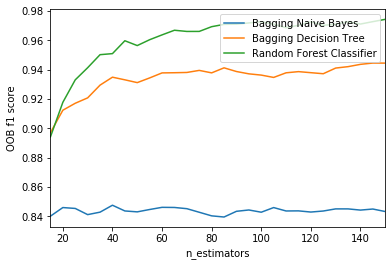

In [10]:
# Generate the "OOB f1" vs. "n_estimators" plot.
for label, clf_f1 in macro_f1_score_oobs.items():
    xs, ys = zip(*clf_f1)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB f1 score")
plt.legend(loc="upper right")
plt.show()

In [19]:
for name, clf in ensemble_clfs :
    print(name)
    clf.fit(X_train,y_train)
    predictions = clf.predict(X_test)
    
    print(f"f1 oob - {macro_f1_score_oob(clf,y_train)}")
    print(f'regular oob {clf.oob_score_}')
    print(f"f1 test - {f1_score(predictions,y_test, average = 'macro')}" )
    print((f"f1 accuracy - {accuracy_score(predictions,y_test)}"))


Bagging Naive Bayes
f1 oob - 0.8432523708768767
f1 test - 0.8659671109998677
f1 accuracy - 0.8648148148148148
oob0.8440731901352426
Bagging Decision Tree
f1 oob - 0.9444429454829016
f1 test - 0.9474247378975702
f1 accuracy - 0.9462962962962963
oob0.9451073985680191
Random Forest Classifier
f1 oob - 0.9742929476572982
f1 test - 0.9747603187465869
f1 accuracy - 0.9740740740740741
oob0.9745425616547335


## Boosting

In [12]:
ada = AdaBoostClassifier(random_state=0)
min_estimators = 1
max_estimators = 5
for i in range(min_estimators, max_estimators + 1, 1):
        ada.set_params(n_estimators=i)
        ada.fit(X_train,y_train)
        predictions = ada.predict(X_train)
        print(f"f1 train - {f1_score(predictions,y_train, average = 'macro')}" )
predictions = ada.predict(X_test)
print(f"f1 test - {f1_score(predictions,y_test, average = 'macro')}" )

f1 train - 0.09808603965450775
f1 train - 0.21138880084268127
f1 train - 0.21138880084268127
f1 train - 0.21138880084268127
f1 train - 0.21138880084268127
f1 test - 0.18136823308349898


In [ ]:
We can see that adaboost has a really hard time ion this kind of data. 

In [1]:
X_train.shape

NameError: name 'X_train' is not defined